In [1]:
# ---
# Name: CNN autoencoder script
# Version: 0.1.0
# ---

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Import spectra dataset
data = pd.concat([pd.read_csv('/Users/navin/Library/CloudStorage/Dropbox-AIZOTH/研究/Navin/spectra_gen/ir-spectra-gen/data/IR_spectra/Broadened_IR_Spectra/2C9C_b3lyp_broadened_Gauessview_gamma_5_dx2.csv'),pd.read_csv('/Users/navin/Library/CloudStorage/Dropbox-AIZOTH/研究/Navin/spectra_gen/ir-spectra-gen/data/IR_spectra/Broadened_IR_Spectra/10C_b3lyp_broadened_Gauessview_gamma_5_dx2.csv')], axis = 0)

df = data.drop(columns = ['smiles'])

# Train-val-test split
X_train, X_val= train_test_split(df, test_size = 0.2)
X_val, X_test= train_test_split(X_val, test_size = 0.5)

print(df.columns)

# Standardize model
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

# Convert to tensor
X_train_tensor = torch.tensor(X_train_s, dtype = torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_s, dtype = torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_s, dtype = torch.float32).unsqueeze(1)

Index(['400', '402', '404', '406', '408', '410', '412', '414', '416', '418',
       ...
       '3982', '3984', '3986', '3988', '3990', '3992', '3994', '3996', '3998',
       '4000'],
      dtype='object', length=1801)


In [3]:
# Create dataloader
train_loader = DataLoader(X_train_tensor, batch_size= 32, shuffle = True)
val_loader = DataLoader(X_val_tensor, batch_size = 32)
test_loader = DataLoader(X_test_tensor, batch_size= 32)

# CNN-based Autoencoder
class CNNAutoEncoder(nn.Module):
    def __init__(self, input_length):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, stride=2, padding=2),  # (batch, 16, input/2)
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),  # (batch, 32, input/4)
            nn.ReLU(),
        )

        # Latent dimension flatten size
        dummy_input = torch.zeros(1, 1, input_length)
        with torch.no_grad():
            enc_out = self.encoder(dummy_input)
            self.enc_out_shape = enc_out.shape  # (1, 32, actual_length)
            self.flatten_dim = enc_out.numel()

        self.fc_enc = nn.Linear(self.flatten_dim, 50)
        self.fc_dec = nn.Linear(50, self.flatten_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=5, stride=2, padding=2, output_padding=1),
        )

    def forward(self, x):
        z = self.encoder(x)
        z_flat = z.view(x.size(0), -1)
        z_latent = self.fc_enc(z_flat)
        z_decoded = self.fc_dec(z_latent)
        z_decoded = z_decoded.view(x.size(0), self.enc_out_shape[1], self.enc_out_shape[2])
        x_recon = self.decoder(z_decoded)
        return x_recon, z_latent

    
# Model
input_length = X_train_tensor.shape[-1]
model = CNNAutoEncoder(input_length).to('cpu')

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
best_val_loss = float('inf')
best_model_state = None

# Training loop
for epoch in range(50):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        pred, _ = model(batch)
        # Slice prediction to match input length
        pred = pred[:, :, :batch.shape[2]]
        loss = criterion(pred, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            pred, _ = model(batch)
            pred = pred[:, :, :batch.shape[2]]  # same slicing for val
            loss = criterion(pred, batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

Epoch 1 | Train Loss: 0.345648 | Val Loss: 0.607988
Epoch 2 | Train Loss: 0.273117 | Val Loss: 0.491757
Epoch 3 | Train Loss: 0.200579 | Val Loss: 0.443726
Epoch 4 | Train Loss: 0.245974 | Val Loss: 0.372460
Epoch 5 | Train Loss: 0.192077 | Val Loss: 0.286084
Epoch 6 | Train Loss: 0.193129 | Val Loss: 0.212404
Epoch 7 | Train Loss: 0.151932 | Val Loss: 0.258282
Epoch 8 | Train Loss: 0.154702 | Val Loss: 0.248910
Epoch 9 | Train Loss: 0.143553 | Val Loss: 0.241511
Epoch 10 | Train Loss: 0.123499 | Val Loss: 0.225935
Epoch 11 | Train Loss: 0.149270 | Val Loss: 0.204034
Epoch 12 | Train Loss: 0.206783 | Val Loss: 0.170371
Epoch 13 | Train Loss: 0.129506 | Val Loss: 0.235270
Epoch 14 | Train Loss: 0.115819 | Val Loss: 0.178063
Epoch 15 | Train Loss: 0.130161 | Val Loss: 0.293652
Epoch 16 | Train Loss: 0.161593 | Val Loss: 0.223128
Epoch 17 | Train Loss: 0.132393 | Val Loss: 0.316747
Epoch 18 | Train Loss: 0.111045 | Val Loss: 0.490781
Epoch 19 | Train Loss: 0.113349 | Val Loss: 0.178321
Ep

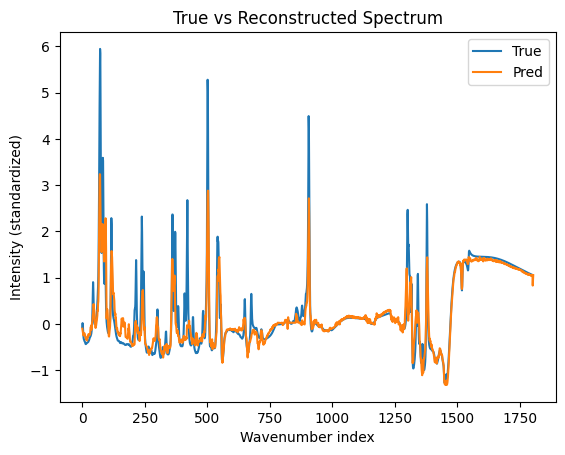

In [20]:
# Load best model
model.load_state_dict(best_model_state)

# Test set evaluation (plot example spectrum)
model.eval()
with torch.no_grad():
    for batch in test_loader:
        pred, _ = model(batch)
        break

batch_np = batch.squeeze(1).numpy()
pred_np = pred.squeeze(1).numpy()

import matplotlib.pyplot as plt
plt.plot(batch_np[28], label='True', linestyle='-')
plt.plot(pred_np[28], label='Pred', linestyle='-')
plt.legend()
plt.title('True vs Reconstructed Spectrum')
plt.xlabel('Wavenumber index')
plt.ylabel('Intensity (standardized)')
plt.show()